In [19]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from collections import Counter


In [2]:
from imblearn.over_sampling import RandomOverSampler


In [34]:
test_participant = 7
data = pd.read_csv('../Collected Data/preprocessed/'+str(test_participant)+'/preprocessed_traindata.csv')

X = data.drop('Label', axis=1) #features
y = data['Label']
y = y.str.strip()
len(X)
X.tail()


,avg_accX,min_accX,max_accX,var_accX,std_accX,avg_accY,min_accY,max_accY,var_accY,std_accY,...,min_pressure,max_pressure,var_pressure,range_pressure,std_pressure,slope_pressure,kurtosis_pressure,Pressure_below_avg,Pressure_above_avg,skew_pressure
3507,-0.809971,-1.554565,-0.175537,0.073450,0.270678,0.082148,-0.605957,0.537964,0.037936,0.194528,...,973.910452,974.642794,0.021780,0.732341,0.147394,0.000779,-0.090597,0.41,0.58,-0.673246
3508,-0.816060,-1.334839,-0.460693,0.032082,0.178889,0.068148,-0.305542,0.486938,0.020173,0.141855,...,974.234792,974.941654,0.019595,0.706862,0.139806,0.000657,1.160887,0.60,0.40,1.154018
3509,-0.584475,-1.200439,0.796143,0.271896,0.520518,0.140101,-0.144409,1.050781,0.055111,0.234344,...,974.589560,975.285295,0.028057,0.695734,0.167207,0.001318,-0.372125,0.59,0.41,0.561499
3510,-0.101199,-0.367554,0.250977,0.054057,0.231755,-0.006255,-0.217163,0.222290,0.006255,0.078838,...,974.049544,974.714518,0.039974,0.664974,0.199294,-0.003342,-1.027596,0.58,0.42,0.442752
3511,-0.263720,-0.287964,-0.250610,0.000082,0.009005,0.048271,-0.012573,0.079590,0.001198,0.034459,...,974.235140,974.404892,0.001170,0.169752,0.034056,0.000349,0.286911,0.36,0.64,-0.506659


In [21]:
label_encoder = LabelEncoder()

encoded_traininglabels = label_encoder.fit_transform(y)

print("Encoded Labels:", encoded_traininglabels)

Encoded Labels: [0 0 0 ... 3 0 0]


In [22]:
label_mapping = dict(zip(encoded_traininglabels, y))
print("Label Mapping:", label_mapping)

Label Mapping: {0: 'Null', 1: 'lift down', 3: 'stairs down', 4: 'stairs up', 2: 'lift up'}


In [23]:
y = encoded_traininglabels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [24]:
print(sorted(Counter(y_train).items()))
print(sorted(Counter(y).items()))

[(0, 1375), (1, 161), (2, 174), (3, 491), (4, 555)]
[(0, 1735), (1, 194), (2, 214), (3, 618), (4, 685)]


In [25]:
Xtrain_resampled, ytrain_resampled = RandomOverSampler(sampling_strategy= "not majority").fit_resample(X_train, y_train)
print (sorted(Counter(ytrain_resampled).items())) 

X_resampled, y_resampled = RandomOverSampler(sampling_strategy= "not majority").fit_resample(X, y)
print (sorted(Counter(y_resampled).items()))

[(0, 1375), (1, 1375), (2, 1375), (3, 1375), (4, 1375)]
[(0, 1735), (1, 1735), (2, 1735), (3, 1735), (4, 1735)]


In [ ]:
# Define the parameter grid
param_grid = {
    'n_estimators': [200, 225, 250, 275, 300, 325, 350],  # Testing different values for n_estimators
    'max_depth': [None,5, 10, 15, 20],       # Testing different values for max_depth
}

# Initializing Random Forest classifier
rf_classifier = RandomForestClassifier(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=10, scoring='accuracy', n_jobs=-1)

# Perform grid search to find the best hyperparameters
grid_search.fit(X, y)

# Get the best model and best parameters
best_rf = grid_search.best_estimator_
best_params = grid_search.best_params_

print("Best Parameters:", best_params)


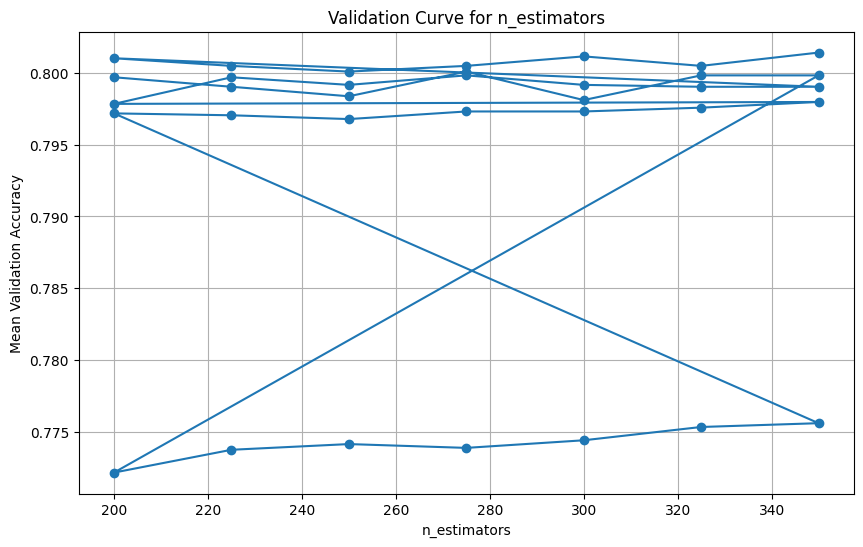

In [11]:
import matplotlib.pyplot as plt

# Extract and plot mean validation scores
mean_scores = grid_search.cv_results_['mean_test_score']
params_n_estimators = [param['n_estimators'] for param in grid_search.cv_results_['params']]

plt.figure(figsize=(10, 6))
plt.plot(params_n_estimators, mean_scores, marker='o')
plt.xlabel('n_estimators')
plt.ylabel('Mean Validation Accuracy')
plt.title('Validation Curve for n_estimators')
plt.grid(True)
plt.show()


In [42]:
# Training the model using the best parameters
final_rf = RandomForestClassifier(max_depth=15,n_estimators=350, random_state=42)
final_rf.fit(Xtrain_resampled, ytrain_resampled)

RandomForestClassifier(max_depth=15, n_estimators=350, random_state=42)

In [43]:

y_pred = final_rf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.8782608695652174


In [44]:
data = pd.read_csv('../Collected Data/preprocessed/7/preprocessed_testdata.csv')

xtest = data.drop('Label', axis=1) #features
ytest = data['Label']

In [45]:
encoded_testinglabels = label_encoder.fit_transform(ytest)
label_mapping = dict(zip(encoded_testinglabels, ytest))
print("Label Mapping:", label_mapping)
print(encoded_testinglabels)

Label Mapping: {0: 'Null', 4: 'stairs up', 1: 'lift down', 3: 'stairs down', 2: 'lift up'}
[0 0 4 4 4 4 4 4 4 4 4 4 4 4 4 0 0 0 0 0 1 1 1 0 0 0 0 4 4 4 4 4 4 4 4 4 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 4 4 4 4 4 4 4 4 4 4 0 0 0 3 3 3 3 3 3 3 0
 0 0 0 2 2 2 0 0 0 2 2 2 0 0 0 1 1 1 1 0 0 0 0 2 2 2 0 0 3 3 3 3 3 3 0 0 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 0 0 0 0]


In [46]:
y_pred = final_rf.predict(xtest)
ytest = encoded_testinglabels
accuracy = accuracy_score(ytest, y_pred)
print("Accuracy:", accuracy)
f1_micro = f1_score(ytest, y_pred, average='micro')
f1_macro = f1_score(ytest, y_pred, average='macro')
f1_weighted = f1_score(ytest, y_pred, average='weighted')
print("F1 Score micro:", f1_micro)
print("F1 Score macro:", f1_macro)
print("F1 Score weighted:", f1_weighted)

Accuracy: 0.9534883720930233
F1 Score micro: 0.9534883720930233
F1 Score macro: 0.9367388632872504
F1 Score weighted: 0.9530735660105503


In [41]:
print(ytest, y_pred)

[0 0 4 4 4 4 4 4 4 4 4 4 4 4 4 0 0 0 0 0 1 1 1 0 0 0 0 4 4 4 4 4 4 4 4 4 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 4 4 4 4 4 4 4 4 4 4 0 0 0 3 3 3 3 3 3 3 0
 0 0 0 2 2 2 0 0 0 2 2 2 0 0 0 1 1 1 1 0 0 0 0 2 2 2 0 0 3 3 3 3 3 3 0 0 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 0 0 0 0] [0 0 4 4 4 4 4 4 4 4 4 4 4 4 4 0 0 0 0 0 1 1 1 0 0 0 0 4 4 4 4 4 4 4 4 4 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 4 4 4 4 4 4 4 4 4 4 0 0 0 3 3 3 3 3 3 3 0
 0 0 0 2 2 2 0 0 0 2 2 2 0 0 0 1 1 1 1 0 0 0 0 2 2 2 0 0 3 3 3 3 3 3 0 0 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 0 0 0 0]


In [47]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [48]:
import numpy as np
cm = confusion_matrix(ytest, y_pred,  labels=np.arange(len(label_encoder.classes_)))

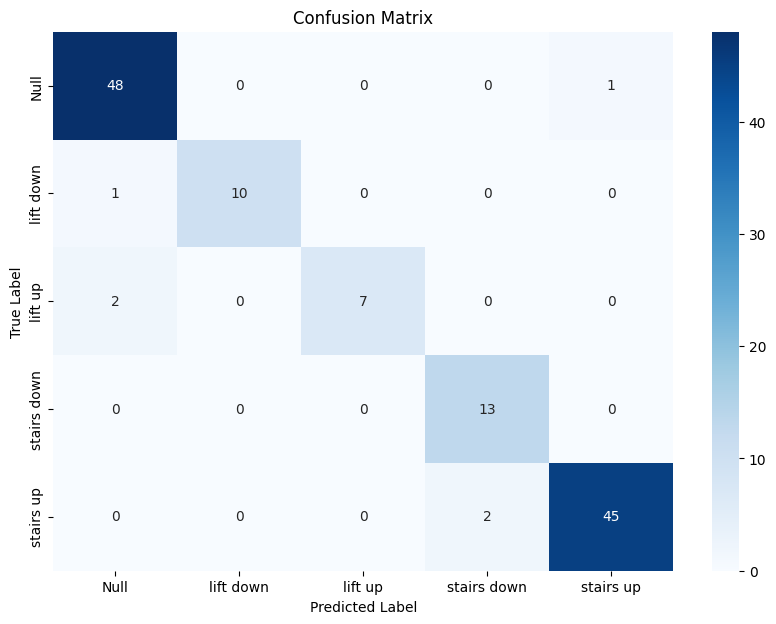

In [49]:
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [50]:
importances = final_rf.feature_importances_

# Create a DataFrame for better visualization
feature_names = X.columns
feature_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort the DataFrame by importance
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

In [51]:
feature_importances

,Feature,Importance
26,slope_pressure,0.286465
18,var_magnitude,0.077125
19,std_magnitude,0.076717
25,std_pressure,0.042840
17,max_magnitude,0.042364
23,var_pressure,0.042031
27,kurtosis_pressure,0.034469
16,min_magnitude,0.033441
1,min_accX,0.032649
24,range_pressure,0.026012
